---
title: Summarise large datasets with spatio-temporal bins
subtitle: A case study with the Geolife dataset
date: 2024-06-25
categories: [geospatial, H3, KeplerGl, pings binning, Geolife, dataset "profile", tutorial]
image: images/cover.png
toc: true
draft: false
colab: <a href="https://colab.research.google.com/github/SebastianoF/GeoDsBlog/blob/master/posts/gds-2024-06-20-dataset-profiling/index.ipynb" target="_blank"><img src="images/colab.svg"></a>
github: <a href="https://github.com/SebastianoF/GeoDsBlog/blob/master/posts/gds-2024-06-20-dataset-profiling/index.ipynb" target="_blank">  <img src="images/github.svg"> </a>
twitter-card:
  image: images/cover.png
---

It can be impractical or useless to try to show all the data on a map when investigating a large dataset of pings, i.e. the points of a trajectory having `latitude`, `longitude` and `timestamp` as its attributes. 

In his blog post I present a simple trick to aggregate pings into spatio-temporal [bins](https://en.wikipedia.org/wiki/Data_binning), leveraging on the ubiquitous Uber [H3 Spatial Indexing](https://www.uber.com/en-GB/blog/h3/). This helps visualizing where and when a dataset is distributed on a map, producing visualisations like the one below:

![](images/dataset_profile.gif)


This example uses the open source [Geolife dataset](https://www.microsoft.com/en-us/research/publication/geolife-gps-trajectory-dataset-user-guide/): after parsing it and adding a minimal EDA, I bin all the pings in space with H3, and in time with a fixed length time window. In the last step the resulting **dataset profile** is then plotted with KeplerGl.

As for any of the posts in this blog, the text is sourced directly from a jupyter notebook, and all the results are reproducible with your local python environment.

### Outline

- @sec-python-env Python environment setup
- @sec-download-the-dataset Download geolife dataset
- @sec-load-dataset Load the dataset
- @sec-eda Exploratory data analysis (EDA)
- @sec-space-time-binning Space-time binning with H3
- @sec-dataset-profile-visualisation Dataset profile visualisation



::: {.callout-tip}
To create the `.gif` animation on mac, take a scree recording with a software like QuickTime player `video.mov`, then following [this guide](https://gist.github.com/SheldonWangRJT/8d3f44a35c8d1386a396b9b49b43c385), run the command:

```bash
ffmpeg -i video.mov -pix_fmt rgb8 -r 10 output.gif && gifsicle -O3 output.gif -o output.gif
```

Making sure that you have `ffmpeg` and `gifsicle` installed beforehand:

```bash
brew install ffmpeg
brew install gifsicle
```

:::

## Python environment setup {#sec-python-env}

Create a virtualenvironment and install the required libraries.

Suggested lightweight method:

```bash
virtualenv venv -p python3.11
source venv/bin/activate
pip install -r https://raw.githubusercontent.com/SebastianoF/GeoDsBlog/master/posts/gds-2024-06-20-dataset-profiling/requirements.txt
```

Where the requirement file is sourced directly from the repository, and contains the following libraries and their pinned dependencies:

```text
altair==5.3.0
geopandas==1.0.1
gitpython==3.1.43
h3==3.7.7
keplergl==0.3.2
matplotlib==3.9.0
pyarrow==16.1.0
tqdm==4.66.4
```

You can look under `requirements.txt` [in the repository](https://github.com/SebastianoF/GeoDsBlog/blob/master/posts/gds-2024-06-20-dataset-profiling/requirements.txt) for the pinned dependency tree.


In [1]:
import datetime as dt
import io
import zipfile
from copy import deepcopy
from pathlib import Path

import altair as alt
import geopandas as gpd
import git
import h3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from IPython.display import Image
from shapely import Polygon
from tqdm import tqdm

plt.style.use('dark_background')
alt.renderers.set_embed_options(theme="dark")

KEPLER_OUTPUT = False  # for blog visualisation: set to true if running on jupyter notebook

## Download the dataset {#sec-download-the-dataset}

The dataset can be downloaded manually, or running the following commands:

In [2]:
url_download_geolife_dataset = "https://download.microsoft.com/download/F/4/8/F4894AA5-FDBC-481E-9285-D5F8C4C4F039/Geolife%20Trajectories%201.3.zip"

try:
    path_root = Path(git.Repo(Path().cwd(), search_parent_directories=True).git.rev_parse("--show-toplevel"))
except (git.exc.InvalidGitRepositoryError, ModuleNotFoundError):
    path_root = Path().cwd()
    
path_data_folder = path_root / "z_data" 
path_data_folder.mkdir(parents=True, exist_ok=True)

path_unzipped_dataset = path_data_folder / "Geolife Trajectories 1.3"

if not path_unzipped_dataset.exists():
    r = requests.get(url_download_geolife_dataset)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(path_data_folder)

print("Dataset ready")

Dataset ready


## Load the dataset {#sec-load-dataset}

The folder structure of the Geolife dataset is not as linear as it could be.

- The trajectories are divided into 182 folders numbered from `000` to `181`. 
- Each folder contains a subfolder called `Trajectory` containing a series of `.plt` files.
- Some folders also contain a file called `labels.txt`, containing time intervals and transportation modes.
- There are two different datetime formats.
- Within the zip folder there is also a pdf file with the dataset description.

To load the files I implemented a class to load the files and enrich them with the labels when they are available. The time formats are converted to pandas datetimes[^1].

The main parser method has also a boolean flag `parse_only_if_labels`. `False` by default, when set to `True` only the files with the labels are parsed.

[^1]: For a refresher about datetime manipulation, [here](https://sebastianof.github.io/GeoDsBlog/posts/gds-2024-01-24-timestamp/) is an detailed tutorial on this topic.


In [3]:
# Columns names

COLS_TRAJECTORY = [
    "latitude",
    "longitude",
    "none",
    "altitude",
    "date_elapsed",
    "date",
    "time",
]

COLS_TRAJECTORY_TO_LOAD = [
    "latitude",
    "longitude",
    "altitude",
    "date",
    "time",
]

COLS_LABELS = [
    "start_time",
    "end_time",
    "transportation_mode",
]

COLS_RESULTS = [
    "entity_id",
    "latitude",  # degrees
    "longitude",  # degrees
    "altitude",  # meters (int)
    "timestamp",  # UNIX (int)
    "transport",  # only if the labels.txt file is there
]

# Format codes

LABELS_FC = "%Y/%m/%d %H:%M:%S"
TRAJECTORY_FC = "%Y-%m-%d %H:%M:%S"


class GeoLifeDataLoader:
    def __init__(self, path_to_geolife_folder: str | Path) -> None:
        self.pfo_geolife = path_to_geolife_folder
        pfo_data = Path(self.pfo_geolife) / "Data"
        self.dir_per_subject: dict[int, Path] = {int(f.name): f for f in pfo_data.iterdir() if f.is_dir()}

    def to_pandas_per_device(
        self,
        device_number: int,
        leave_progressbar=True,
    ) -> tuple[pd.DataFrame]:
        path_to_device_folder = self.dir_per_subject[device_number]
        pfo_trajectory = path_to_device_folder / "Trajectory"
        pfi_labels = path_to_device_folder / "labels.txt"
        df_labels = None
        df_trajectory = None

        list_trajectories = [plt_file for plt_file in pfo_trajectory.iterdir() if str(plt_file).endswith(".plt")]
        list_dfs = []
        for traj in tqdm(list_trajectories, leave=leave_progressbar):
            df_sourced = pd.read_csv(traj, skiprows=6, names=COLS_TRAJECTORY, usecols=COLS_TRAJECTORY_TO_LOAD)
            df_sourced["altitude"] = df_sourced["altitude"].apply(lambda x: x * 0.3048)  # feets to meters
            df_sourced["timestamp"] = df_sourced.apply(
                lambda x: dt.datetime.strptime(x["date"] + " " + x["time"], TRAJECTORY_FC),
                axis=1,
            )
            df_sourced = df_sourced.assign(entity_id=f"device_{device_number}", transport=None)
            df_sourced = df_sourced[COLS_RESULTS]
            list_dfs.append(df_sourced)
        df_trajectory = pd.concat(list_dfs)

        if pfi_labels.exists():
            df_labels = pd.read_csv(pfi_labels, sep="\t")
            df_labels.columns = COLS_LABELS
            df_labels["start_time"] = df_labels["start_time"].apply(lambda x: dt.datetime.strptime(x, LABELS_FC))
            df_labels["end_time"] = df_labels["end_time"].apply(lambda x: dt.datetime.strptime(x, LABELS_FC))
        if df_labels is not None:
            for _, row in tqdm(df_labels.iterrows(), leave=leave_progressbar):
                mask = (df_trajectory.timestamp > row.start_time) & (df_trajectory.timestamp <= row.end_time)
                df_trajectory.loc[mask, "transport"] = row["transportation_mode"]

        return df_trajectory, df_labels

    def to_pandas(self, parse_only_if_labels: bool = False) -> pd.DataFrame:
        list_dfs_final = []
        for idx in tqdm(self.dir_per_subject.keys()):
            df_trajectory, df_labels = self.to_pandas_per_device(idx, leave_progressbar=False)
            if parse_only_if_labels:
                if df_labels is not None:
                    list_dfs_final.append(df_trajectory)
                else: 
                    pass
            else:
                list_dfs_final.append(df_trajectory)
            
        return pd.concat(list_dfs_final)


### Load and save to parquet 

To speed up next loading phase, I save to parquet after loading from the `.plt` files the first time.

In this way it will take less time to reload the dataset to continue the analysis.

In [4]:
path_complete_parquet = path_data_folder / "GeolifeTrajectories.parquet"

if not path_complete_parquet.exists():
    # this takes about 5 minutes
    gdl = GeoLifeDataLoader(path_unzipped_dataset)
    df_geolife = gdl.to_pandas(parse_only_if_labels=True)
    df_geolife = df_geolife.reset_index(drop=True)
    df_geolife.to_parquet(path_complete_parquet)

In [5]:
# this takes 2 seconds (MAC book air, 8GB RAM)
df_geolife = pd.read_parquet(path_complete_parquet)
print(df_geolife.shape)
df_geolife.head()

(24876977, 6)


,entity_id,latitude,longitude,altitude,timestamp,transport
0,device_135,39.974294,116.399741,149.9616,2009-01-03 01:21:34,None
1,device_135,39.974292,116.399592,149.9616,2009-01-03 01:21:35,None
2,device_135,39.974309,116.399523,149.9616,2009-01-03 01:21:36,None
3,device_135,39.974320,116.399588,149.9616,2009-01-03 01:21:38,None
4,device_135,39.974365,116.399730,149.6568,2009-01-03 01:21:39,None


## Exploratory data analysis (EDA) {#sec-eda}


In [6]:
map_unique_values = {}
for col in df_geolife.columns:
    map_unique_values.update({col: df_geolife[col].nunique()})
df_unique_values = pd.Series(map_unique_values).to_frame(name="unique values")
del map_unique_values
df_unique_values.head(len(df_geolife.columns))

,unique values
entity_id,182
latitude,4698617
longitude,4839004
altitude,987052
timestamp,17994493
transport,11


In [7]:
sum_na = df_geolife.isna().sum()
sum_na_perc = ((100 * df_geolife.isna().sum()) / len(df_geolife)).apply(lambda x: f"{round(x, 1)} %")
pd.concat([sum_na.to_frame(name="num nan"), sum_na_perc.to_frame(name="percentage")], axis=1)

,num nan,percentage
entity_id,0,0.0 %
latitude,0,0.0 %
longitude,0,0.0 %
altitude,0,0.0 %
timestamp,0,0.0 %
transport,19442892,78.2 %


In [8]:
print(f"time covered:           {df_geolife['timestamp'].min()} -> {df_geolife['timestamp'].max()}")
print(f"Number of devices:      {len(df_geolife['entity_id'].unique())}")
print(f"Number of pings:        {len(df_geolife)}")
print(f"Avg pings per device:   {round( len(df_geolife) / len(df_geolife['entity_id'].unique()) , 2):_}")

time covered:           2000-01-01 23:12:19 -> 2012-07-27 08:31:20
Number of devices:      182
Number of pings:        24876977
Avg pings per device:   136_686.69


quantiles: 3359.0 - 35181.5 - 143041.5


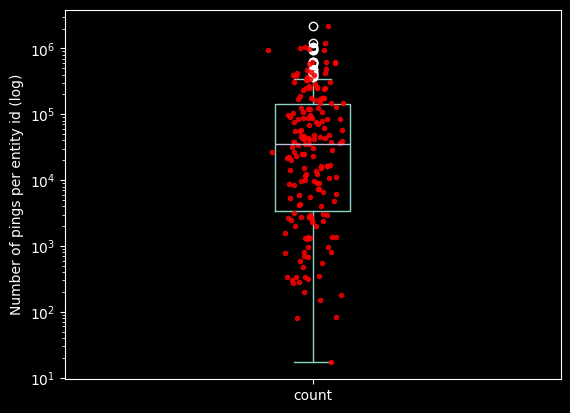

In [9]:
se_devices_count = df_geolife["entity_id"].value_counts().sort_values(ascending=False)

ax = se_devices_count.plot.box()
ax.set_yscale('log')
ax.plot(np.random.normal(1, 0.03, size=len(se_devices_count)), se_devices_count.to_numpy(), 'r.', alpha=0.8)
ax.set_ylabel("Number of pings per entity id (log)")

quantiles = se_devices_count.quantile([.25, .5, .75]).to_list()
print(f"quantiles: {quantiles[0]} - {quantiles[1]} - {quantiles[2]}" )

### Examine the outliers

In [10]:
print(f"longitude interval: {df_geolife['longitude'].min()}, {df_geolife['longitude'].max()}")
print(f"latitude interval: {df_geolife['latitude'].min()}, {df_geolife['latitude'].max()}")

df_lon_out_of_range = df_geolife[(df_geolife['longitude'] > 180) | (df_geolife['longitude'] < -180)]
df_lat_out_of_range = df_geolife[(df_geolife['latitude'] > 90) | (df_geolife['latitude'] < -90)]
print(f"Number of longitudes out of range {len(df_lon_out_of_range)} ({round(100 * len(df_lon_out_of_range) / len(df_geolife), 10)} %)")
print(f"Number of latitudes out of range  {len(df_lat_out_of_range)}  ({round(100 * len(df_lat_out_of_range) / len(df_geolife), 10)} %)")

longitude interval: -179.9695933, 179.9969416
latitude interval: 1.044024, 64.751993
Number of longitudes out of range 0 (0.0 %)
Number of latitudes out of range  0  (0.0 %)


There is only one ping outside the standard lat-lon range.

- In general out of range pings has to be considered individually to understand their origin. They can be legit and going out of range when the device is crossing the antimeridian, or they can be the result of a faulty correction algorithm, or a faulty data type conversion, or other unknown unknowns.
- In the examined case we have only one point that is out of range. The goal of this post is creating a profile for a dataset, so I dropped the outlier without feeling too guilty about it!

In [11]:
df_geolife = df_geolife[(df_geolife['longitude'] <= 180) & (df_geolife['longitude'] >= -180) & (df_geolife['latitude'] <= 90) & (df_geolife['latitude'] >= -90)]

## Space-time binning with H3 {#sec-space-time-binning}

In this section I:

- Bin the dataset in time with a fixed time interval.
- Bin the dataset in space with h3.
- Combine the time and space indexes in a bin index.
- Group by the pings over the index and compute their size.
- Use h3 to add the geometry of each row, turning the dataframe into a geodataframe.

In [12]:
H3_RESOLUTION = 8
TIME_RESOLUTION = "48h"

In [13]:
# 2 mins 50
df_geolife["time_bins"] = df_geolife.set_index("timestamp").index.floor(TIME_RESOLUTION)
df_geolife["h3"] = df_geolife.apply(lambda row: h3.geo_to_h3(row["latitude"], row["longitude"], H3_RESOLUTION), axis=1)

df_geolife.head()

,entity_id,latitude,longitude,altitude,timestamp,transport,time_bins,h3
0,device_135,39.974294,116.399741,149.9616,2009-01-03 01:21:34,None,2009-01-02,8831aa5555fffff
1,device_135,39.974292,116.399592,149.9616,2009-01-03 01:21:35,None,2009-01-02,8831aa5555fffff
2,device_135,39.974309,116.399523,149.9616,2009-01-03 01:21:36,None,2009-01-02,8831aa5555fffff
3,device_135,39.974320,116.399588,149.9616,2009-01-03 01:21:38,None,2009-01-02,8831aa5555fffff
4,device_135,39.974365,116.399730,149.6568,2009-01-03 01:21:39,None,2009-01-02,8831aa5555fffff


In [14]:
# 30 seconds
df_bins_space_time = pd.Series(df_geolife["time_bins"].astype(str) + "_" +  df_geolife["h3"]).to_frame(name="bins").groupby("bins").size().to_frame(name="count")
df_bins_space_time.head()

,count
bins,
1999-12-31_8831aa50c5fffff,2
1999-12-31_8831aa50cdfffff,1
2007-04-11_8831aa5017fffff,1
2007-04-11_8831aa5023fffff,1
2007-04-11_8831aa5027fffff,1


In [15]:
df_bins_space_time["timestamp"] = pd.to_datetime(df_bins_space_time.index.map(lambda x: x.split("_")[0]))
df_bins_space_time["h3"] = df_bins_space_time.index.map(lambda x: x.split("_")[1])
df_bins_space_time.head()

,count,timestamp,h3
bins,,,
1999-12-31_8831aa50c5fffff,2,1999-12-31,8831aa50c5fffff
1999-12-31_8831aa50cdfffff,1,1999-12-31,8831aa50cdfffff
2007-04-11_8831aa5017fffff,1,2007-04-11,8831aa5017fffff
2007-04-11_8831aa5023fffff,1,2007-04-11,8831aa5023fffff
2007-04-11_8831aa5027fffff,1,2007-04-11,8831aa5027fffff


In [16]:
# 15 seconds - 1.2million rows
geometry=list(df_bins_space_time["h3"].apply(lambda x: Polygon(h3.h3_to_geo_boundary(x, geo_json=True))))
gdf_bins_space_time = gpd.GeoDataFrame(df_bins_space_time, geometry=geometry)
print(gdf_bins_space_time.shape)
gdf_bins_space_time.head()

(394264, 4)


,count,timestamp,h3,geometry
bins,,,,
1999-12-31_8831aa50c5fffff,2,1999-12-31,8831aa50c5fffff,"POLYGON ((116.32271 39.9925, 116.32038 39.9884..."
1999-12-31_8831aa50cdfffff,1,1999-12-31,8831aa50cdfffff,"POLYGON ((116.32234 39.99982, 116.32001 39.995..."
2007-04-11_8831aa5017fffff,1,2007-04-11,8831aa5017fffff,"POLYGON ((116.30762 39.99021, 116.30529 39.986..."
2007-04-11_8831aa5023fffff,1,2007-04-11,8831aa5023fffff,"POLYGON ((116.27782 39.97829, 116.2755 39.9742..."
2007-04-11_8831aa5027fffff,1,2007-04-11,8831aa5027fffff,"POLYGON ((116.27047 39.97348, 116.26814 39.969..."


## Dataset profile visualisation {#sec-dataset-profile-visualisation }

Now that we have the the geolife dataset binned in space and time we can visualise the results with KeplerGl.

In [17]:
import json
from pathlib import Path, PosixPath

from keplergl import KeplerGl


class KeplerConfigManager:
    """Save, load and list config files for KeplerGl""" 
    
    def __init__(self, path_to_folder: PosixPath | None= None):
        if path_to_folder is None:
            path_to_folder = Path().cwd() / "kepler_configs"
        self.path_to_folder = path_to_folder
        self.path_to_folder.mkdir(parents=True, exist_ok=True)
        
    @staticmethod
    def _check_name(name_config: str):
        if name_config.endswith(".json"):
            raise ValueError("Name of the config must not include the extension '.json' .")
        
    def _parse_name(self, name_config: str) -> PosixPath:
        return self.path_to_folder / (name_config + ".json")

    def list_available_configs(self):
        return [f.stem for f in self.path_to_folder.glob("*.json")]
        

    def save_config(self, k_map: KeplerGl, name_config: str):
        self._check_name(name_config)
        with self._parse_name(name_config).open("w+", encoding="UTF-8") as file_target: 
            json.dump(k_map.config, file_target, indent=4)
        
    
    def load_config(self, name_config: str):
        self._check_name(name_config)
        return json.loads(self._parse_name(name_config).read_text(encoding="UTF-8"))
    
kcm = KeplerConfigManager()

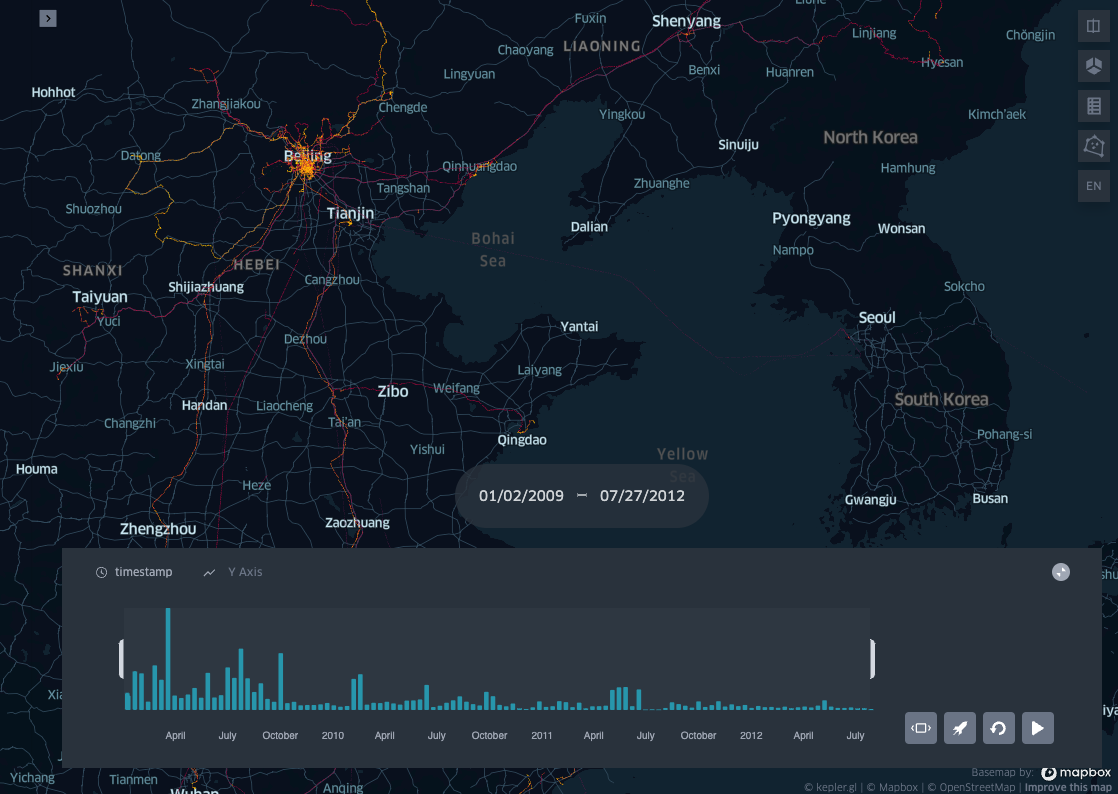

In [22]:
config_map = kcm.load_config("configs_map_binning")

if KEPLER_OUTPUT:
    map1 = KeplerGl(
        data=deepcopy(
            {
                "hex_binning": gdf_bins_space_time[gdf_bins_space_time["timestamp"].dt.year > 2008].reset_index(drop=True).drop(columns=["h3"]),  # limit to the first 200_000
            }
        ), 
        config=config_map,
        height=800
    )
    display(map1)
else:
    display(Image("images/dataset_profile.png"))

In [19]:
if False:  # overwrite kepler map configs
    kcm.save_config(map1, "configs_map_binning")